In [1]:
using DifferentialEquations, LinearAlgebra, Distributions, Plots, LaTeXStrings

 $\beta = (X^T X)^{-1}X^T \vec{y}$

In [2]:
linear_reg(X, y) = inv(transpose(X)*X)*transpose(X)*y;

function kinetic_model!(du, u, p, t)
    cA, cB, cC, cD, cE, cF, cG = u
    k1, k2, k3, k4, k5, k6 = p
    du[1] = - k1*cA - k4*cA - k5*cA*cE
    du[2] = k1*cA - k2*cB - k3*cB
    du[3] = k2*cB - k4*cC
    du[4] = k4*cA - k3*cD
    du[5] = k3*cB - k5*cA*cE
    du[6] = k5*cA*cE - k6*cF*cG^2
    du[7] = - k6*cF*cG^2
end;

In [3]:
tspan = (0.0, 20.0)
teval = range(0, 20, 500)
p = [0.3 0.1 0.1 0.4 0.02 0.5]
u0 = [0.5, 0.0, 0.0, 0.01, 0.0, 0.3, 0.5]
prob = ODEProblem(kinetic_model!, u0, tspan, p)
D_nom = Array(solve(prob, saveat=teval))[4, :]
Dmax_nom = maximum(D_nom);

In [4]:
function global_sensitivity(p; ψ=0.75, N=1000, prob=prob, t_eval=teval)
    
    Lp = length(p)
    lp = p.*(1 - ψ)
    up = p.*(1 + ψ)
    krs = Array{Float64, 2}(undef, N, Lp)
    for j = 1:Lp
        krs[:, j] = rand(Uniform(lp[j], up[j]), N, 1)
    end
    
    D_mtx = Array{Float64, 2}(undef, N, length(t_eval))
    D_max = Array{Float64, 2}(undef, N, 1)
    for i = 1:N
        prob = remake(prob; p=krs[i, :])
        solD = Array(solve(prob, saveat=t_eval))[4, :]
        D_mtx[i, :] = solD
        D_max[i] = maximum(solD)
    end
    Dict("D_matrix"=>D_mtx, "D_max"=>D_max, "k_rand"=>krs, "t"=>t_eval)
end;

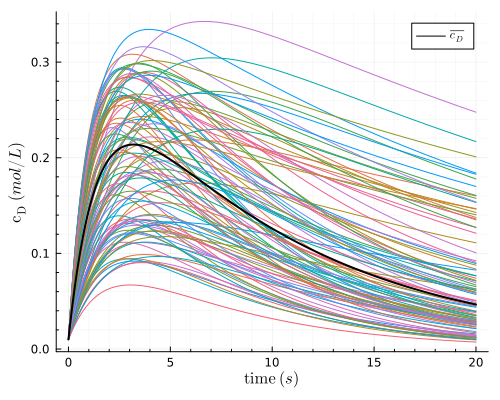

In [5]:
gs_plot = global_sensitivity(p; N=100)
plot(gs_plot["t"], transpose(gs_plot["D_matrix"]), ylabel=L"$C_{D}\,\,(mol/L)}$", label=false)
plot!(teval, D_nom, ls=:solid, lw=2.0, c=:black, label=L"\overline{c_{D}}")
plot!(xlabel=L"$\mathrm{time}\,\,(s)$", ylabel=L"$\mathrm{c_{D}}\,\,(mol/L)$",
      minorgrid=true, size=(500,400))

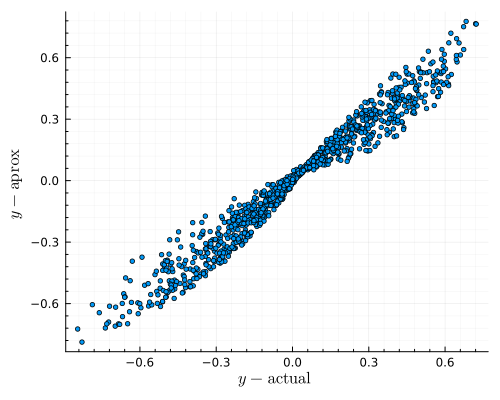

In [6]:
D_dct = global_sensitivity(p; N=1000)
X = (p .- D_dct["k_rand"])./p
y = (Dmax_nom .- D_dct["D_max"])./Dmax_nom
Sᵢ = linear_reg(X, y)
y_aprox = sum(Sᵢ'.*X; dims=2)
scatter(y, y_aprox, label=false, markersize=2.5, minorgrid=true, size=(500,400))
plot!(xlabel=L"$y-\mathrm{actual\,\,}$", ylabel=L"$y-\mathrm{aprox\,\,}$")

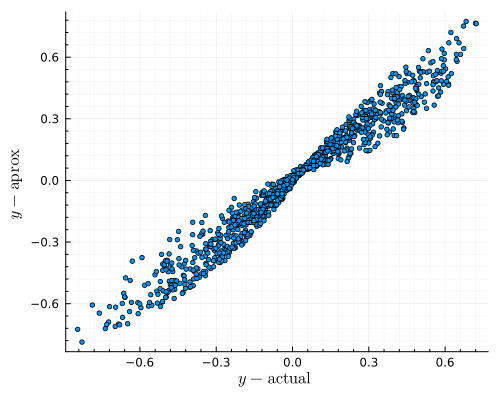

In [7]:
k56 = X[:, 5].*X[:, 6]
X_ = hcat(X, k56)
Sᵢ_ = linear_reg(X_, y)
yaprox_ = sum(Sᵢ_'.*X_; dims=2);
scatter(y, yaprox_, label=false, markersize=2.5, minorgrid=true, size=(500,400))
plot!(xlabel=L"$y-\mathrm{actual\,\,}$", ylabel=L"$y-\mathrm{aprox\,\,}$")

***